In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
# Import the required packages

import numpy as np
import matplotlib.pyplot as plt
import lightcones.linalg as ll
import lightcones.models as lm
import lightcones.jumps as lj
import lightcones.space as ls
from scipy.linalg import expm
import math

In [3]:
# quantum top

j = 20

# chaotic system is quantum top
top = lm.top(j)
# ancilla is also quantum top of the same j
aux = top

# initial states
psi_0 = top.vac()
psi_aux_0 = aux.vac()

S = []

# top evolution during one kick period
for k in np.arange(0,7,0.3):
    tau = 1
    p = 1.7
    Hy = p / tau * top.j_y
    Hz = k / 2 / top.j * (top.j_z - 0.1 * top.eye()) @ (top.j_z - 0.1 * top.eye())
    Hy_ = Hy.todense()
    Hz_ = Hz.todense()
    Uy = expm(-1j*Hy_)
    Uz = expm(-1j*Hz_)
    Utop = Uz @ Uy 

    # we will consider a bipartite of top \otimes ancilla
    bp = ls.bipartite(top.dimension, aux.dimension)
        
    # interaction with the ancilla
    g = 0.1
    Hint = g * ll.kron(top.j_y, aux.j_y)
    Hint_ = Hint.todense()
    Uint = expm(-1j*Hint_)

    ln_P = 0

    # iterate evolutions
    n = 200
    n_skip = 10
    psi = psi_0
    for i in range(n + n_skip):
        # 1 kick period evolution
        psi = Utop @ psi
        # entangle with the ancilla in its ground state
        psi_bp = bp.kron(psi, psi_aux_0)
        psi_bp = Uint @ psi_bp
        # trace out ancilla
        rho_top = bp.trace_out_R(psi_bp)
        # sample quantum jump
        jump_ind, jump_basis, jump_P = lj.make_jump_(rho_top)
        # update state
        psi = jump_basis[:, jump_ind]
        # update ln_P
        if i >= n_skip:
            ln_P += -math.log(jump_P[jump_ind])
    
    S.append(ln_P / n)
    

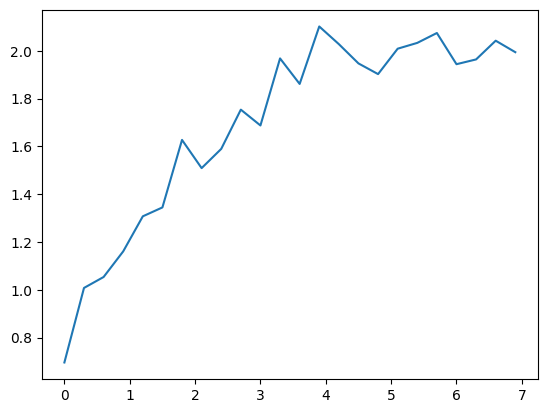

In [5]:
plt.plot(np.arange(0,7,0.3), np.array(S))